<a href="https://colab.research.google.com/github/iamsatvikv/weather-ml-forecasting/blob/main/weather_ml_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

sns.set(style="whitegrid")  # nicer graphs


In [ ]:
df = pd.read_csv("/content/weather_forecast_data.csv")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (2500, 6)


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [ ]:
df.index = pd.date_range(start="2020-01-01", periods=len(df), freq="D")
df.index.name = "Date"

df.head()


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
Date,,,,,,
2020-01-01,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
2020-01-02,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2020-01-03,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
2020-01-04,23.622080,74.367758,7.050551,67.255282,982.632013,rain
2020-01-05,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [ ]:
# Numeric columns to clean
numeric_cols = ["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]

# Clean numeric columns
for col in numeric_cols:
    df[col] = (
        df[col].astype(str)
               .str.replace("%", "", regex=False)
               .str.replace(",", "", regex=False)
               .str.replace("[^0-9.-]", "", regex=True)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Clean Rain (rain → 1, no rain → 0)
df["Rain"] = df["Rain"].astype(str).str.lower().str.strip()
df["Rain"] = df["Rain"].replace({"rain":1, "no rain":0})
df["Rain"] = pd.to_numeric(df["Rain"], errors="coerce")

# Fill missing values
df = df.ffill().bfill()

df.head()


/tmp/ipython-input-1791281268.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Rain"] = df["Rain"].replace({"rain":1, "no rain":0})


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
Date,,,,,,
2020-01-01,23.720338,89.592641,7.335604,50.501694,1032.378759,1
2020-01-02,27.879734,46.489704,5.952484,4.990053,992.614190,0
2020-01-03,25.069084,83.072843,1.371992,14.855784,1007.231620,0
2020-01-04,23.622080,74.367758,7.050551,67.255282,982.632013,1
2020-01-05,20.591370,96.858822,4.643921,47.676444,980.825142,0


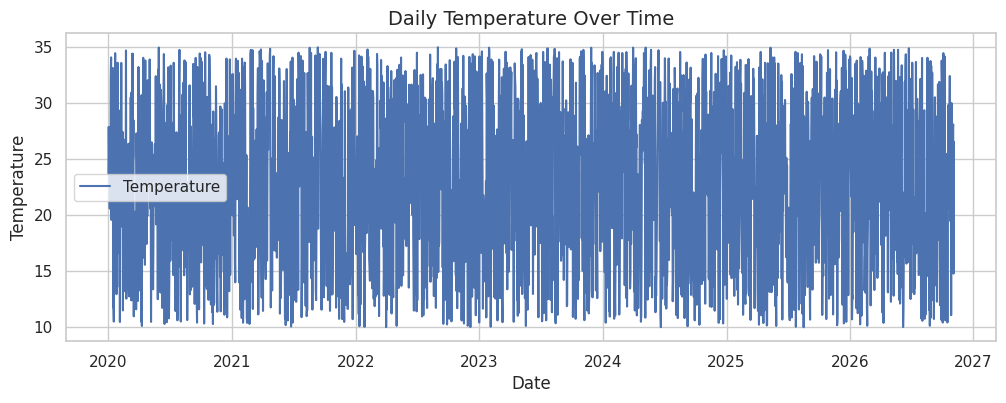

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df["Temperature"], label="Temperature")
plt.title("Daily Temperature Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()


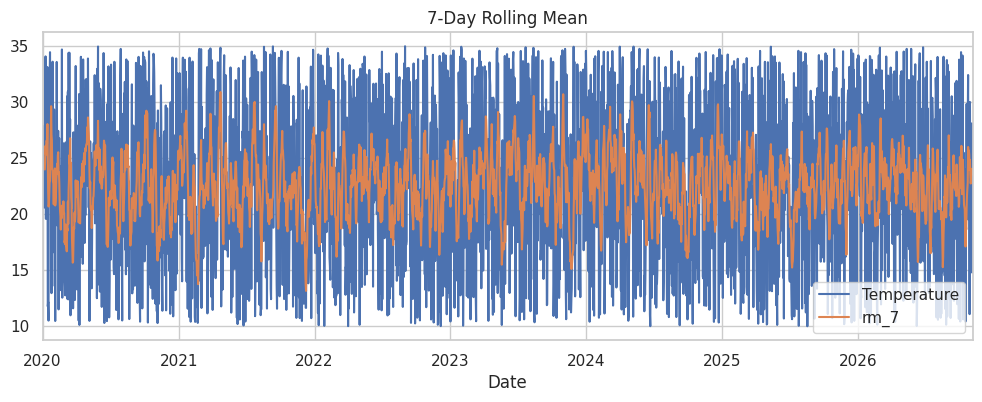

In [ ]:
df["rm_7"] = df["Temperature"].rolling(7).mean()
df["std_7"] = df["Temperature"].rolling(7).std()

df[["Temperature", "rm_7"]].plot(figsize=(12,4), title="7-Day Rolling Mean")
plt.show()


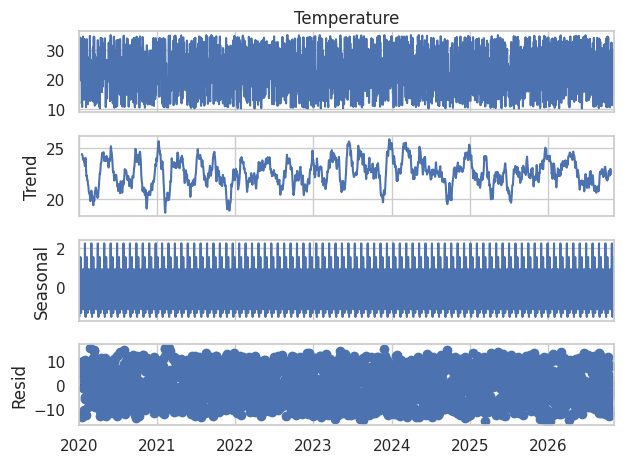

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df["Temperature"], period=30)
decomp.plot()
plt.show()


In [ ]:
data = df.copy()
target = "Temperature"

# Target lag features
for lag in [1,3,7,14]:
    data[f"{target}_lag_{lag}"] = data[target].shift(lag)

# Rolling mean windows
for w in [7,14,30]:
    data[f"{target}_rm_{w}"] = data[target].rolling(w).mean()

# Exogenous lag features
for col in ["Humidity","Wind_Speed","Cloud_Cover","Pressure","Rain"]:
    data[f"{col}_lag_1"] = data[col].shift(1)

# Fill missing after shifting
data = data.ffill().bfill()

data.head()


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain,rm_7,std_7,Temperature_lag_1,Temperature_lag_3,Temperature_lag_7,Temperature_lag_14,Temperature_rm_7,Temperature_rm_14,Temperature_rm_30,Humidity_lag_1,Wind_Speed_lag_1,Cloud_Cover_lag_1,Pressure_lag_1,Rain_lag_1
Date,,,,,,,,,,,,,,,,,,,,
2020-01-01,23.720338,89.592641,7.335604,50.501694,1032.378759,1,23.995663,2.646117,23.720338,23.720338,23.720338,23.720338,23.995663,26.021293,24.528008,89.592641,7.335604,50.501694,1032.378759,1.0
2020-01-02,27.879734,46.489704,5.952484,4.990053,992.614190,0,23.995663,2.646117,23.720338,23.720338,23.720338,23.720338,23.995663,26.021293,24.528008,89.592641,7.335604,50.501694,1032.378759,1.0
2020-01-03,25.069084,83.072843,1.371992,14.855784,1007.231620,0,23.995663,2.646117,27.879734,23.720338,23.720338,23.720338,23.995663,26.021293,24.528008,46.489704,5.952484,4.990053,992.614190,0.0
2020-01-04,23.622080,74.367758,7.050551,67.255282,982.632013,1,23.995663,2.646117,25.069084,23.720338,23.720338,23.720338,23.995663,26.021293,24.528008,83.072843,1.371992,14.855784,1007.231620,0.0
2020-01-05,20.591370,96.858822,4.643921,47.676444,980.825142,0,23.995663,2.646117,23.622080,27.879734,23.720338,23.720338,23.995663,26.021293,24.528008,74.367758,7.050551,67.255282,982.632013,1.0


In [ ]:
n = len(data)
test_size = int(n * 0.2)

train = data.iloc[:-test_size]
test  = data.iloc[-test_size:]

X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]


In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=14,
    random_state=42
)

rf.fit(X_train_s, y_train)
rf_pred = rf.predict(X_test_s)

print("RF MAE:", mean_absolute_error(y_test, rf_pred))
print("RF RMSE:", math.sqrt(mean_squared_error(y_test, rf_pred)))


RF MAE: 5.181152785369765
RF RMSE: 6.343917476404122


In [ ]:
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb.fit(X_train_s, y_train)
xgb_pred = xgb.predict(X_test_s)

print("XGB MAE:", mean_absolute_error(y_test, xgb_pred))
print("XGB RMSE:", math.sqrt(mean_squared_error(y_test, xgb_pred)))


XGB MAE: 5.260420646826609
XGB RMSE: 6.492312805149194


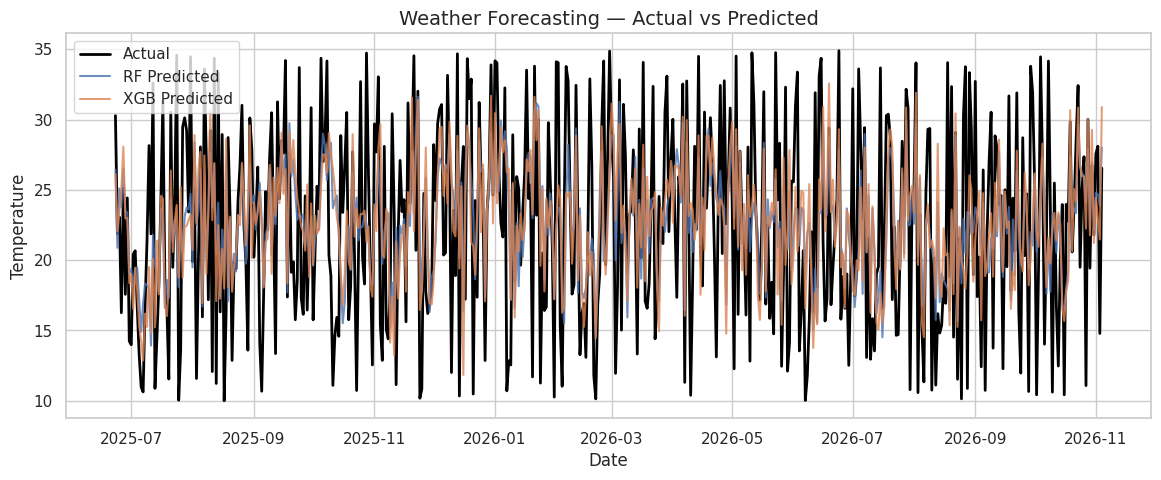

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2, color='black')
plt.plot(y_test.index, rf_pred, label="RF Predicted", alpha=0.8)
plt.plot(y_test.index, xgb_pred, label="XGB Predicted", alpha=0.8)
plt.title("Weather Forecasting — Actual vs Predicted", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()


In [ ]:
results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, xgb_pred)
    ],
    "RMSE": [
        math.sqrt(mean_squared_error(y_test, rf_pred)),
        math.sqrt(mean_squared_error(y_test, xgb_pred))
    ]
})

results


,Model,MAE,RMSE
0,Random Forest,5.181153,6.343917
1,XGBoost,5.260421,6.492313


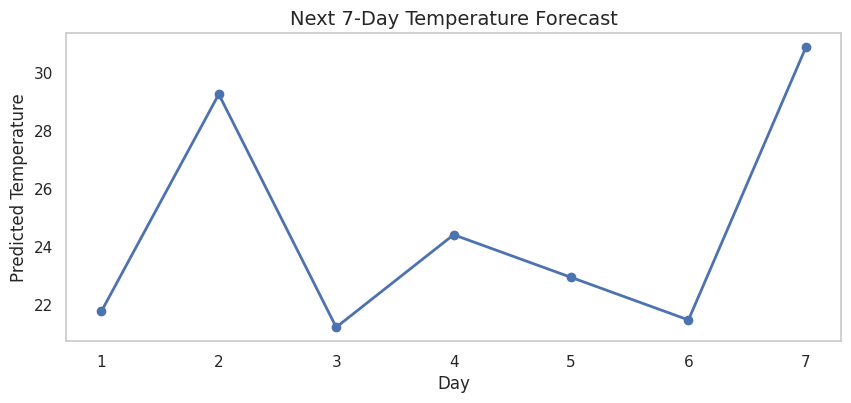

In [ ]:
future_7 = xgb_pred[-7:]

plt.figure(figsize=(10,4))
plt.plot(range(1,8), future_7, marker='o', linewidth=2)
plt.title("Next 7-Day Temperature Forecast", fontsize=14)
plt.xlabel("Day")
plt.ylabel("Predicted Temperature")
plt.grid()
plt.show()
